# Unet

- Model implematation: https://medium.com/@ashishbisht0307/swin-transformer-based-unet-architecture-for-semantic-segmentation-with-pytorch-code-91e779334e8e
- Paper: https://arxiv.org/abs/2105.05537


In [1]:
%pip install einops timm imutils torchvision lightning torchmetrics

You should consider upgrading via the '/Users/haily/.pyenv/versions/3.10.4/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
try:
    from utils import get_seg_lightning_modules, get_segmentation_plot, local_paths, kaggle_paths
except Exception as e:
    import sys
    sys.path.append("/kaggle/input/segmentation-util")
    from utils import SegModule, SegDM, local_paths, kaggle_paths


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FAST = True # Fast dev: run 1 batch only
LOCAL = True
ACCELERATOR = 'mps'

dataset_paths = local_paths if LOCAL else kaggle_paths

## Unet Model


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncodeBlock(nn.Module):
    """Apply 2 successive layers of 3x3 convolutions and ReLU activation."""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x, maxpool_first=False):
        if maxpool_first:
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        return self.encode(x)

class DecodeBlock(nn.Module):
    """Upsample using 2x2 transposed convolution layers, concatenate with skip
    connections, and then apply 2 successive layers of 3x3 convolutions and ReLU."""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        ## Upsample need to halve the feature maps to have the same shape 
        ## with skip connection 
        self.upsample = nn.ConvTranspose2d(
            in_channels,
            in_channels // 2,
            kernel_size=2,
            stride=2,
        )
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x, skip):
        x = self.upsample(x)
        # Crop skip tensor (based on
        # https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py)
        height_diff = skip.size()[2] - x.size()[2]
        width_diff = skip.size()[3] - x.size()[3]
        pad = [
            width_diff // 2, width_diff - width_diff // 2, # Pad last dimension
            height_diff // 2, height_diff - height_diff // 2, # Pad second-to-last dimension
        ]
        x = F.pad(x, pad)
        x = torch.cat([x, skip], dim=1)
        return self.decode(x)
class SimpleUNet(nn.Module):
    """Basic U-Net model architecture."""

    def __init__(self, in_channels=3, n_classes=2):
        super().__init__()

        # Create encoder (channel dimensions based on original U-Net paper)
        self.encode_1 = EncodeBlock(in_channels, 64)
        self.encode_2 = EncodeBlock(64, 128)
        self.encode_3 = EncodeBlock(128, 256)
        self.encode_4 = EncodeBlock(256, 512)

        self.encode_last = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Create decoder
        self.decode_1 = DecodeBlock(1024, 512)
        self.decode_2 = DecodeBlock(512, 256)
        self.decode_3 = DecodeBlock(256, 128)
        self.decode_4 = DecodeBlock(128, 64)

        # Original paper used a 1x1 convolution to map features to n_classes
        self.decode_last = nn.Conv2d(64, n_classes, kernel_size=1) #1x1 Conv2d


    def forward(self, x):
        # Encoding
        x1 = self.encode_1(x)
        x2 = self.encode_2(x1, maxpool_first=True)
        x3 = self.encode_3(x2, maxpool_first=True)
        x4 = self.encode_4(x3, maxpool_first=True)
        x = self.encode_last(x4)
        # Decoding
        x = self.decode_1(x, skip=x4)
        x = self.decode_2(x, skip=x3)
        x = self.decode_3(x, skip=x2)
        x = self.decode_4(x, skip=x1)
        outputs = self.decode_last(x)
        return outputs


## Shenzhen


In [4]:
s_dm, s_module, s_trainer = get_seg_lightning_modules(
    data_paths=dataset_paths['shenzen'],
    model_name='shenzen_unet',
    model=SimpleUNet(3, 2),
    fast=FAST,
    accelerator=ACCELERATOR
)

s_trainer.fit(s_module, s_dm)
s_trainer.test(s_module, s_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SwinUNet         | 3.1 M  | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.219    Total estimated model params size (MB)


318 examples in the training set...
106 examples in the validation set...


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 1/1 [00:10<00:00,  0.10it/s, train_loss=0.734, val_loss=0.670]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:10<00:00,  0.10it/s, train_loss=0.734, val_loss=0.670]
142 examples in the test set...


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s]
f1: 0.7627410888671875
accuracy: 0.6385440826416016
precision: 0.7729299068450928
recall: 0.7528173923492432
mean_iou: 0.6073625683784485


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6533982753753662     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6533982753753662}]

142 examples in the test set...
tensor([0, 1])
tensor([0, 1])
tensor([0, 1])


[<Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>]

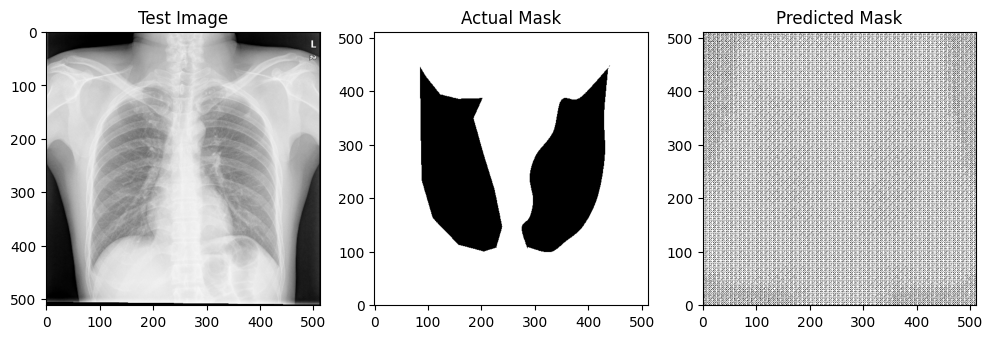

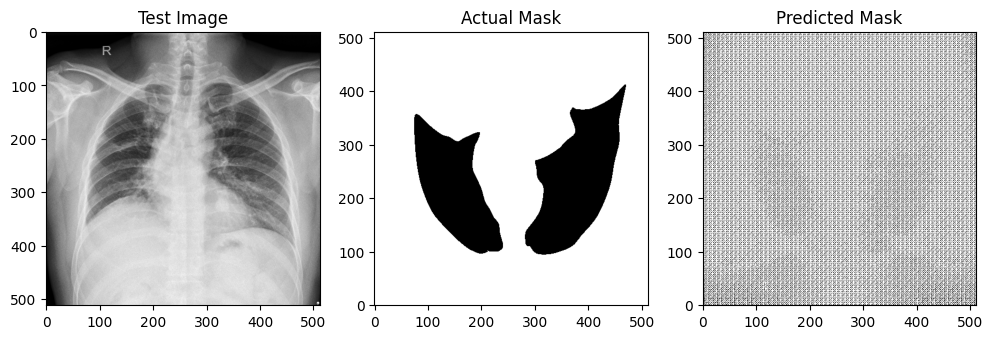

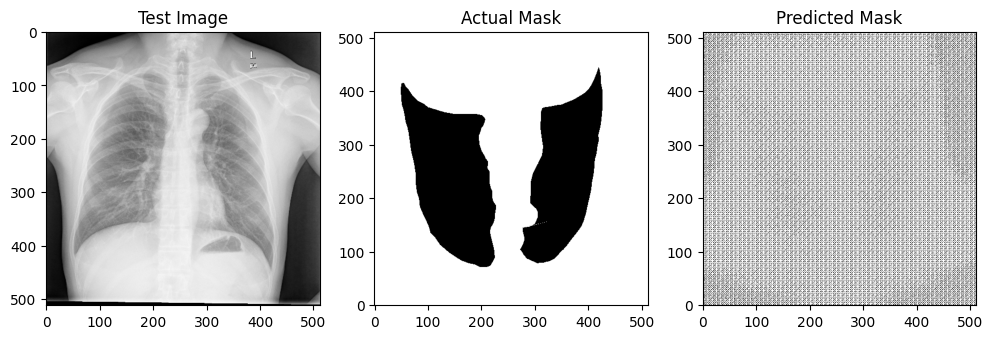

In [5]:
s_dm.setup('test')
get_segmentation_plot(
    s_module.model, 
    s_dm.test, 
    device='cpu')

## Darwin


In [9]:
d_dm, d_module, d_trainer = get_seg_lightning_modules(
    data_paths=dataset_paths['darwin'],
    model_name='darwin_unet',
    model=SimpleUNet(3, 2),
    fast=FAST,
    accelerator=ACCELERATOR
)

d_trainer.fit(d_module, d_dm)
d_trainer.test(d_module, d_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SwinUNet         | 3.1 M  | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.219    Total estimated model params size (MB)


3434 examples in the training set...
1145 examples in the validation set...
Epoch 0: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, train_loss=0.730, val_loss=0.652]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, train_loss=0.730, val_loss=0.652]
1527 examples in the test set...


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
f1: 0.7353814840316772
accuracy: 0.6051597595214844
precision: 0.6474042534828186
recall: 0.8510298728942871
mean_iou: 0.5712742805480957


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6718647480010986     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6718647480010986}]

1527 examples in the test set...
tensor([0, 1])
tensor([0, 1])
tensor([0, 1])


[<Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>]

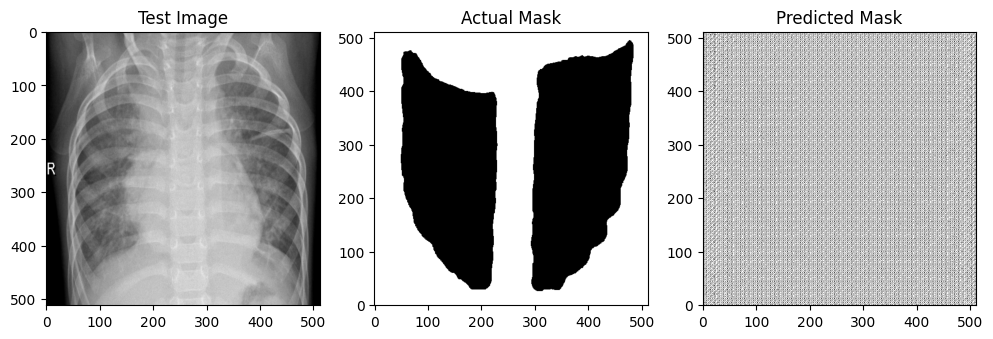

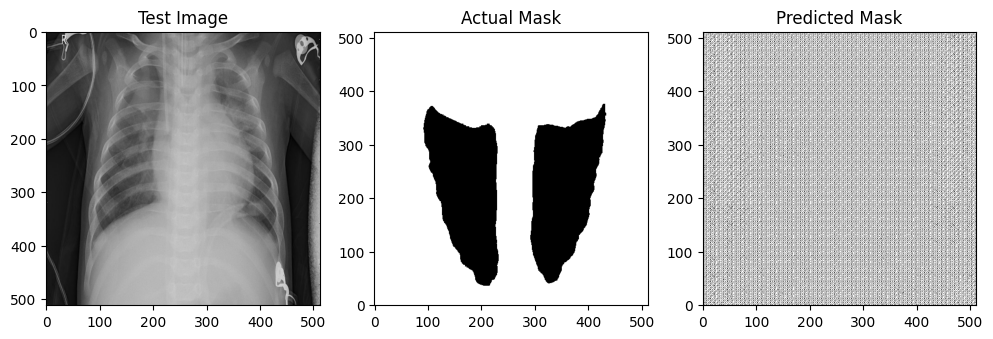

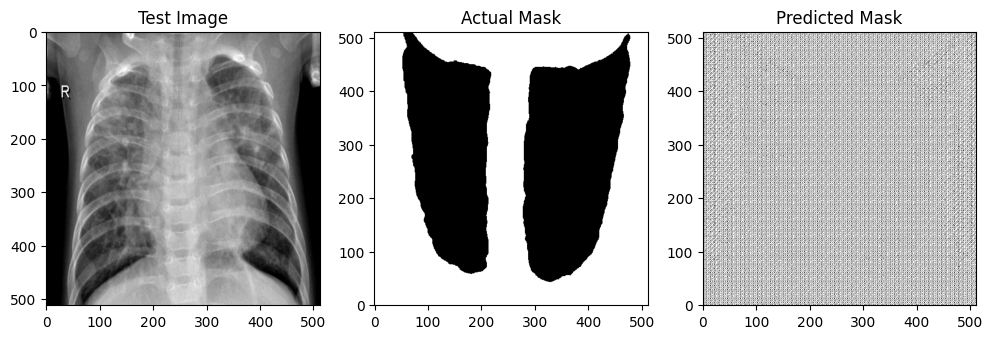

In [7]:
d_dm.setup('test')
get_segmentation_plot(
    d_module.model, 
    d_dm.test, 
    device='cpu')

## Covid


In [11]:
c_dm, c_module, c_trainer = get_seg_lightning_modules(
    data_paths=dataset_paths['covid'],
    model_name='covid_unet',
    model=SimpleUNet(3, 2),
    fast=FAST,
    accelerator=ACCELERATOR
)
c_trainer.fit(c_module, c_dm)
c_trainer.test(c_module, c_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SwinUNet         | 3.1 M  | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.219    Total estimated model params size (MB)


2034 examples in the training set...
678 examples in the validation set...
Epoch 0: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, train_loss=0.830, val_loss=0.690]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, train_loss=0.830, val_loss=0.690]
904 examples in the test set...


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
f1: 0.699383556842804
accuracy: 0.5762100219726562
precision: 0.7620232701301575
recall: 0.6462598443031311
mean_iou: 0.527076244354248


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6755099296569824     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6755099296569824}]

904 examples in the test set...
tensor([0, 1])
tensor([0, 1])
tensor([0, 1])


[<Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>]

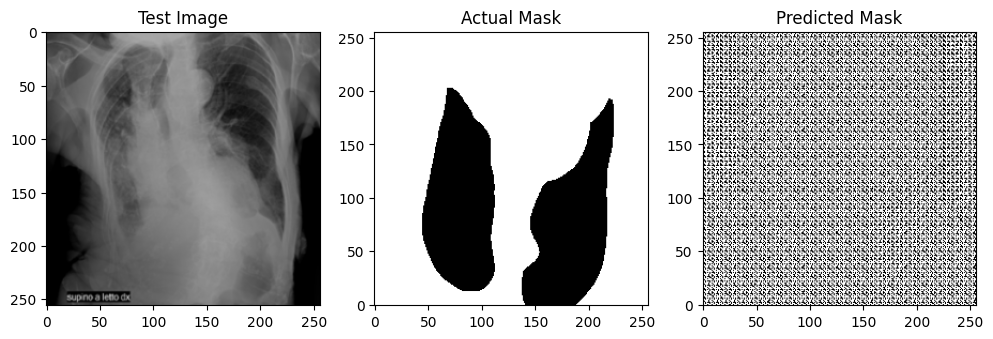

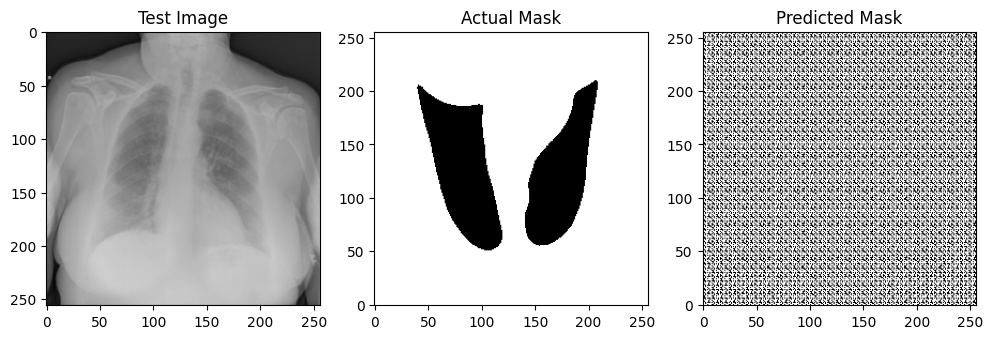

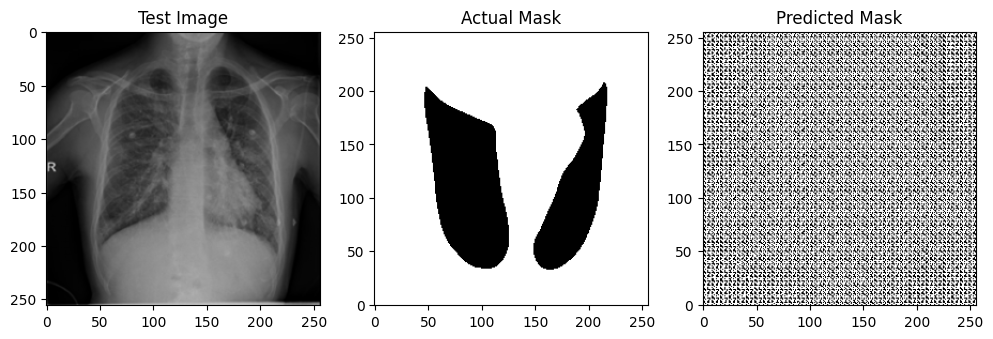

In [12]:
c_dm.setup('test')
get_segmentation_plot(
    c_module.model, 
    c_dm.test, 
    device='cpu')